# HW1
日期: 20250218

## 作業
作業說明 : 繪製每日台股最高成交量的 10 檔股票

## 環境設定

In [78]:
# 套件安裝
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

In [79]:
# 設定繁體中文字型
!apt-get install -qq fonts-noto-cjk  # Google Colab 需要安裝
prop = fm.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")  # 設定字型

## 從臺灣證券交易所 API 讀取資料


In [80]:
url = 'https://openapi.twse.com.tw/v1/exchangeReport/STOCK_DAY_ALL'
response = requests.get(url)
data = response.json()

## 資料整理

In [81]:
# 轉換為 DataFrame
stock_df = pd.DataFrame(data)

# 數據清理
stock_df['TradeValue'] = stock_df['TradeValue'].str.replace(',', '', regex=True)  # 移除逗號
stock_df['TradeValue'] = pd.to_numeric(stock_df['TradeValue'], errors='coerce')  # 轉換為數字

# 移除 NaN 值
stock_df = stock_df.dropna(subset=['TradeValue'])

# 選取每日成交額最高的 10 檔股票
stock_top10 = stock_df.nlargest(10, 'TradeValue')

# 準備資料
names = stock_top10['Name']
trade_values = stock_top10['TradeValue'].values

## 擬合函數定義以及計算

In [82]:
# *定義三次多項式函數
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# 產生 X 軸索引 (從 0 開始，以便對齊)
x = np.arange(len(stock_top10))  # X 軸索引
y = trade_values / 1e6  # 轉換為百萬單位，避免數值過大影響擬合

# 進行擬合
initial_guess = [1, 1, 1, min(y)]  # 設定合理的初始值
popt, _ = curve_fit(cubic_function, x, y, p0=initial_guess, maxfev=10000)
a, b, c, d = popt

# 產生擬合曲線（確保 x_fit 也從 0 開始）
x_fit = np.linspace(0, len(stock_top10) - 1, 100)
y_fit = cubic_function(x_fit, a, b, c, d)  # 使用三次函數擬合

## 繪製圖表

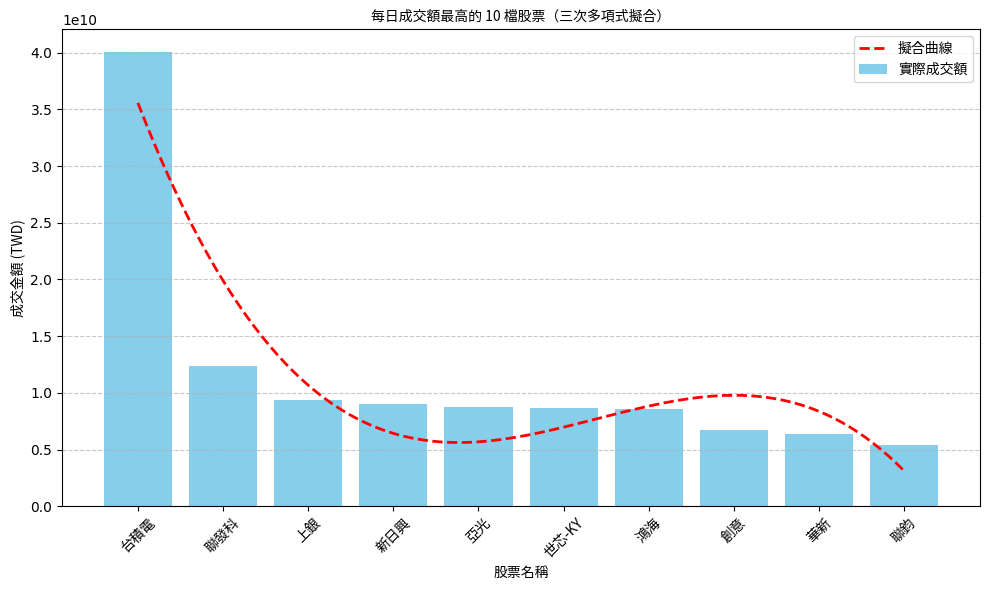

In [83]:
# 繪製圖表
plt.figure(figsize=(10, 6))

# 繪製長條圖
bars = plt.bar(x, trade_values, color='skyblue', label="實際成交額")  # x 軸使用數值索引

# 繪製擬合曲線
plt.plot(x_fit, y_fit * 1e6, color='red', linestyle='--', linewidth=2, label="擬合曲線")

# 確保 X 軸刻度與股票名稱對齊
plt.xticks(ticks=x, labels=names, rotation=45, fontproperties=prop)

# 設定標籤與標題字型
plt.xlabel('股票名稱', fontproperties=prop)
plt.ylabel('成交金額 (TWD)', fontproperties=prop)
plt.title('每日成交額最高的 10 檔股票（三次多項式擬合）', fontproperties=prop)
plt.legend(prop=prop)  # **確保圖例能正常顯示**

# 顯示圖表
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
